In [1]:
import PIL
from PIL import Image
from PIL import ImageFilter
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy import misc
from scipy import ndimage
from scipy.stats import multivariate_normal
from numpy.linalg import norm
import numpy.linalg

In [69]:
def buildImageTiles(imageName):
    #original = ndimage.imread(imagename, flatten=True)
    #original = plt.imread(imagename)
    
    original = Image.open(imageName)

    # SIFT Parameters
    s = 3
    k = 2 ** (1.0 / s)
    # threshold variable is the contrast threshold. Set to at least 1

    # Standard deviations for Gaussian smoothing
    kvec1 = np.array([1.3, 1.6, 1.6 * k, 1.6 * (k ** 2), 1.6 * (k ** 3), 1.6 * (k ** 4)])
    kvec2 = np.array([1.6 * (k ** 2), 1.6 * (k ** 3), 1.6 * (k ** 4), 1.6 * (k ** 5), 1.6 * (k ** 6), 1.6 * (k ** 7)])
    kvec3 = np.array([1.6 * (k ** 5), 1.6 * (k ** 6), 1.6 * (k ** 7), 1.6 * (k ** 8), 1.6 * (k ** 9), 1.6 * (k ** 10)])
    kvec4 = np.array([1.6 * (k ** 8), 1.6 * (k ** 9), 1.6 * (k ** 10), 1.6 * (k ** 11), 1.6 * (k ** 12), 1.6 * (k ** 13)])
    kvectotal = np.array([1.6, 1.6 * k, 1.6 * (k ** 2), 1.6 * (k ** 3), 1.6 * (k ** 4), 1.6 * (k ** 5), 1.6 * (k ** 6), 1.6 * (k ** 7), 1.6 * (k ** 8), 1.6 * (k ** 9), 1.6 * (k ** 10), 1.6 * (k ** 11)])

    # Downsampling images
    #doubled = misc.imresize(original, 200, 'bilinear').astype(int)
    doubled_img = original.resize((2*original.size[0], 2*original.size[1]), PIL.Image.BILINEAR)
    
    #normal = misc.imresize(doubled, 50, 'bilinear').astype(int)
    normal_img = doubled_img.resize((int(float(doubled_img.size[0]/2)), int(float(doubled_img.size[1]/2))), PIL.Image.BILINEAR)
    
    #halved = misc.imresize(normal, 50, 'bilinear').astype(int)
    halved_img = normal_img.resize((int(float(normal_img.size[0]/2)), int(float(normal_img.size[1]/2))), PIL.Image.BILINEAR)
    
    #quartered = misc.imresize(halved, 50, 'bilinear').astype(int)
    quartered_img = halved_img.resize((int(float(halved_img.size[0]/2)), int(float(halved_img.size[1]/2))), PIL.Image.BILINEAR)
    
    #convert image to grey levels then to arrays
    doubled = np.asarray(doubled_img.convert('L'))
    normal = np.asarray(normal_img.convert('L'))
    halved = np.asarray(halved_img.convert('L'))
    quartered = np.asarray(quartered_img.convert('L'))

    # Initialize Gaussian pyramids
    pyrlvl1 = np.zeros((doubled.shape[0], doubled.shape[1], 6))
    pyrlvl2 = np.zeros((normal.shape[0], normal.shape[1], 6))
    pyrlvl3 = np.zeros((halved.shape[0], halved.shape[1], 6))
    pyrlvl4 = np.zeros((quartered.shape[0], quartered.shape[1], 6))

    print("Constructing pyramids...")

    # Construct Gaussian pyramids
    for i in range(0, 6):
        pyrlvl1[:,:,i] = ndimage.filters.gaussian_filter(doubled, kvec1[i])
        
        temp = ndimage.filters.gaussian_filter(doubled, kvec2[i])
        pyrlvl2[:,:,i] = Image.fromarray(temp).resize((int(float(doubled.shape[1]/2)), int(float(doubled.shape[0]/2))), PIL.Image.BILINEAR)
        #pyrlvl2[:,:,i] = misc.imresize(ndimage.filters.gaussian_filter(doubled, kvec2[i]), 50, 'bilinear')
        
        temp = ndimage.filters.gaussian_filter(doubled, kvec3[i])
        pyrlvl3[:,:,i] = Image.fromarray(temp).resize((int(float(doubled.shape[1]/4)), int(float(doubled.shape[0]/4))), PIL.Image.BILINEAR)
        #pyrlvl3[:,:,i] = misc.imresize(ndimage.filters.gaussian_filter(doubled, kvec3[i]), 25, 'bilinear')
        
        temp = ndimage.filters.gaussian_filter(doubled, kvec4[i])
        pyrlvl4[:,:,i] = Image.fromarray(temp).resize((int(float(doubled.shape[1]/8)), int(float(doubled.shape[0]/8))), PIL.Image.BILINEAR)
        #pyrlvl4[:,:,i] = misc.imresize(ndimage.filters.gaussian_filter(doubled, kvec4[i]), 1.0 / 8.0, 'bilinear')

    # Initialize Difference-of-Gaussians (DoG) pyramids
    diffpyrlvl1 = np.zeros((doubled.shape[0], doubled.shape[1], 5))
    diffpyrlvl2 = np.zeros((normal.shape[0], normal.shape[1], 5))
    diffpyrlvl3 = np.zeros((halved.shape[0], halved.shape[1], 5))
    diffpyrlvl4 = np.zeros((quartered.shape[0], quartered.shape[1], 5))

    # Construct DoG pyramids
    for i in range(0, 5):
        diffpyrlvl1[:,:,i] = pyrlvl1[:,:,i+1] - pyrlvl1[:,:,i]
        diffpyrlvl2[:,:,i] = pyrlvl2[:,:,i+1] - pyrlvl2[:,:,i]
        diffpyrlvl3[:,:,i] = pyrlvl3[:,:,i+1] - pyrlvl3[:,:,i]
        diffpyrlvl4[:,:,i] = pyrlvl4[:,:,i+1] - pyrlvl4[:,:,i]
    
    return (doubled_img, normal_img, halved_img, quartered_img, pyrlvl1, pyrlvl2, pyrlvl3, pyrlvl4)

In [81]:
def showPyramidTiles(doubled_img, normal_img, halved_img, quartered_img, pyrlvl1, pyrlvl2, pyrlvl3, pyrlvl4):
     #setting all images in the pyramid for diplaying:
    %matplotlib inline  
    fig = plt.figure()
    fig.add_subplot(1,7,1)
    imgplot = plt.imshow(doubled_img)
    #showing level 1 Gaussian_blurred images:
    #image 0:
    img = Image.fromarray(np.uint8(pyrlvl1[:,:,0] * 255), 'L')
    fig.add_subplot(1,7,2)
    imgplot = plt.imshow(img)
    #image 1:
    img = Image.fromarray(np.uint8(pyrlvl1[:,:,1] * 255), 'L')
    fig.add_subplot(1,7,3)
    imgplot = plt.imshow(img)
    #image 2:
    img = Image.fromarray(np.uint8(pyrlvl1[:,:,2] * 255), 'L')
    fig.add_subplot(1,7,4)
    imgplot = plt.imshow(img)
    #image 3:
    img = Image.fromarray(np.uint8(pyrlvl1[:,:,3] * 255), 'L')
    fig.add_subplot(1,7,5)
    imgplot = plt.imshow(img)
    #image 4:
    img = Image.fromarray(np.uint8(pyrlvl1[:,:,4] * 255), 'L')
    fig.add_subplot(1,7,6)
    imgplot = plt.imshow(img)
    #image 5:
    img = Image.fromarray(np.uint8(pyrlvl1[:,:,5] * 255), 'L')
    fig.add_subplot(1,7,7)
    imgplot = plt.imshow(img)
    
    fig = plt.figure()
    fig.add_subplot(1,7,1)
    imgplot = plt.imshow(normal_img)
    #showing level 2 Gaussian_blurred images:
    #image 0:
    img = Image.fromarray(np.uint8(pyrlvl2[:,:,0] * 255), 'L')
    fig.add_subplot(1,7,2)
    imgplot = plt.imshow(img)
    #image 1:
    img = Image.fromarray(np.uint8(pyrlvl2[:,:,1] * 255), 'L')
    fig.add_subplot(1,7,3)
    imgplot = plt.imshow(img)
    #image 2:
    img = Image.fromarray(np.uint8(pyrlvl2[:,:,2] * 255), 'L')
    fig.add_subplot(1,7,4)
    imgplot = plt.imshow(img)
    #image 3:
    img = Image.fromarray(np.uint8(pyrlvl2[:,:,3] * 255), 'L')
    fig.add_subplot(1,7,5)
    imgplot = plt.imshow(img)
    #image 4:
    img = Image.fromarray(np.uint8(pyrlvl2[:,:,4] * 255), 'L')
    fig.add_subplot(1,7,6)
    imgplot = plt.imshow(img)
    #image 5:
    img = Image.fromarray(np.uint8(pyrlvl2[:,:,5] * 255), 'L')
    fig.add_subplot(1,7,7)
    imgplot = plt.imshow(img)
    
    fig = plt.figure()
    fig.add_subplot(1,7,1)
    imgplot = plt.imshow(halved_img)
    #showing level 3 Gaussian_blurred images:
    #image 0:
    img = Image.fromarray(np.uint8(pyrlvl3[:,:,0] * 255), 'L')
    fig.add_subplot(1,7,2)
    imgplot = plt.imshow(img)
    #image 1:
    img = Image.fromarray(np.uint8(pyrlvl3[:,:,1] * 255), 'L')
    fig.add_subplot(1,7,3)
    imgplot = plt.imshow(img)
    #image 2:
    img = Image.fromarray(np.uint8(pyrlvl3[:,:,2] * 255), 'L')
    fig.add_subplot(1,7,4)
    imgplot = plt.imshow(img)
    #image 3:
    img = Image.fromarray(np.uint8(pyrlvl3[:,:,3] * 255), 'L')
    fig.add_subplot(1,7,5)
    imgplot = plt.imshow(img)
    #image 4:
    img = Image.fromarray(np.uint8(pyrlvl3[:,:,4] * 255), 'L')
    fig.add_subplot(1,7,6)
    imgplot = plt.imshow(img)
    #image 5:
    img = Image.fromarray(np.uint8(pyrlvl3[:,:,5] * 255), 'L')
    fig.add_subplot(1,7,7)
    imgplot = plt.imshow(img)
    
    fig = plt.figure()
    fig.add_subplot(1,7,1)
    imgplot = plt.imshow(quartered_img)
    #showing level 4 Gaussian_blurred images:
    #image 0:
    img = Image.fromarray(np.uint8(pyrlvl4[:,:,0] * 255), 'L')
    fig.add_subplot(1,7,2)
    imgplot = plt.imshow(img)
    #image 1:
    img = Image.fromarray(np.uint8(pyrlvl4[:,:,1] * 255), 'L')
    fig.add_subplot(1,7,3)
    imgplot = plt.imshow(img)
    #image 2:
    img = Image.fromarray(np.uint8(pyrlvl4[:,:,2] * 255), 'L')
    fig.add_subplot(1,7,4)
    imgplot = plt.imshow(img)
    #image 3:
    img = Image.fromarray(np.uint8(pyrlvl4[:,:,3] * 255), 'L')
    fig.add_subplot(1,7,5)
    imgplot = plt.imshow(img)
    #image 4:
    img = Image.fromarray(np.uint8(pyrlvl4[:,:,4] * 255), 'L')
    fig.add_subplot(1,7,6)
    imgplot = plt.imshow(img)
    #image 5:
    img = Image.fromarray(np.uint8(pyrlvl4[:,:,5] * 255), 'L')
    fig.add_subplot(1,7,7)
    imgplot = plt.imshow(img)

In [80]:
[doubled_img, normal_img, halved_img, quartered_img, pyrlvl1, pyrlvl2, pyrlvl3, pyrlvl4] = buildImageTiles('building_small.jpg')

Constructing pyramids...


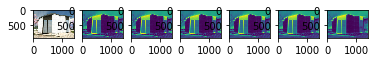

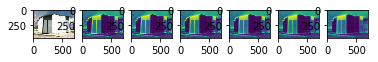

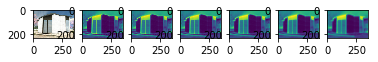

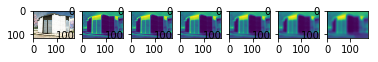

In [82]:
showPyramidTiles(doubled_img, normal_img, halved_img, quartered_img, pyrlvl1, pyrlvl2, pyrlvl3, pyrlvl4)